## Creating Model's Class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)

# loss function use in backpropgataion stage
def cross_entropy(X,y):
    m = y.shape[0]
    p = softmax(X)
    log_likelihood = -np.log(p[range(m),y.argmax(axis=1)])
    loss = np.sum(log_likelihood) / m
    return loss

# softamx function for last layer
def softmax(x):
    return np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum(axis=1, keepdims=True)

# loss function derivation
def delta_cross_entropy(X,y):

    m = y.shape[0]
    grad = softmax(X)
    grad[range(m),y.argmax(axis=1)] -= 1
    grad = grad/m
    return grad
#creating a class for model object, we can train and evaluate models with this class
class NeuralNetwrok:
    def __init__(self,):
        
        self.activation_functions = {'tanh':     {'func' :(lambda x: np.tanh(x)),
                                                  'deriv':(lambda x: 1-np.tanh(x)**2)},
                                     'relu':     {'func' :(lambda x: x*(x > 0)),
                                                  'deriv':(lambda x: 1 * (x>0))},
                                     'sigmoid':  {'func' :(lambda x: 1/(1+np.exp(-x))),
                                                  'deriv':(lambda x: x * (1 - x))},
                                     'softmax':  {'func' :(lambda x: np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum(axis=1, keepdims=True)),
                                                  'deriv':(lambda x: np.exp(x)/np.sum(np.exp(x)) * (1-np.exp(x)/np.sum(np.exp(x))) )}}
        
        self.loss_functions       = {'rmse':     {'func' :(lambda x,y: np.sqrt(((x - y) ** 2).mean())),
                                                  'deriv':(lambda x,y: y-x)},
                                     'cross_ent':{'func' :cross_entropy,
                                                  'deriv':delta_cross_entropy}}

        self.deltas        = []  # keep track for delat values for each layer
        self.neurons       = []  # neurons result will be stored here in each epoch
        self.arch          = []  # basic architecture of the created model
        self.weights       = []  # weights between layers 
        self.actives       = []  # activation function for each layer
        self.n_layers      = -1  # number of layers of model
        self.input         = None   # the input x of data set
        self.target        = None   # the input y of data set
        self.loss_history  = []  # keep track of models loss on train set
        self.val_history   = []  # keep track of models loss on validation set
        self.output        = []  # the last layer result in each epoch
    
    
    
    # using this method we can create new layers for our model
    # the first layer doesn't require any activation function
    # it will also create random weights when we add new layers to the model
    def add_layer(self, input_node, activation_func = None):
        
        self.arch.append(input_node)
        
        if len(self.arch) > 1:
            self.weights.append(np.random.rand(self.arch[-2], self.arch[-1]) - 0.5)
            
            self.actives.append(activation_func)
        
        self.n_layers += 1
    
    # based on the model architecture and paramaters in fit method, 
    # it will calculate each neurons value to reach the final layers
    # each layers activation function will be used from actives attribute
    # and each weight will be used from weights attribute
    def forward_propagation(self,):
        
        func = self.activation_functions[self.actives[0]]['func']
        result = np.dot(self.input, self.weights[0])
        self.neurons.append(func(result))
        
        for i in range(1,self.n_layers):
            func = self.activation_functions[self.actives[i]]['func']
            result = np.dot(self.neurons[i-1], self.weights[i])
            self.neurons.append(func(result))
    
    # first we would see if the loss function is cross entropy or not. 
    # regard to our loss function, it will calculate final weight delta
    # differently. after that we will calculate delta for previous layers
    # and using dot function we will update the weights
    # we can also use optimizers depend on the users choice on the fit method
    def back_propagation(self):
              
            
        func  = self.activation_functions[self.actives[-1]]['func']
        deriv = self.activation_functions[self.actives[-1]]['deriv']   
        
        if self.loss != 'cross_ent':
            loss_func  = self.loss_functions[self.loss]['func']
            loss_deriv = self.loss_functions[self.loss]['deriv']         
            
            loss_value = loss_func(self.neurons[-1], self.target)
            self.loss_history.append(loss_value)
            self.neurons.insert(0,self.input)
            result = loss_deriv(self.target,self.neurons[-1]) * deriv(self.neurons[-1])
            self.deltas.append(result)
        
        elif self.loss == 'cross_ent':

            loss_value = cross_entropy(self.neurons[-1],self.target)
            self.loss_history.append(loss_value)
            self.neurons.insert(0,self.input)
            result = delta_cross_entropy(self.neurons[-1],self.target)
            self.deltas.append(result)
        
        for i in range(2,self.n_layers+1):
            deriv = self.activation_functions[self.actives[-i]]['deriv'] 
            result = np.dot(self.deltas[i-2],self.weights[-i+1].T) * deriv(self.neurons[-i])
            self.deltas.append(result)
        
        self.deltas.reverse()
        self.gs_rec = [0]*(self.n_layers)
        self.v_rec = [0]*(self.n_layers)
        for i in range(self.n_layers):
            dw = np.dot(self.neurons[i].T, self.deltas[i])
            if self.optimizer == 'adagrad':
                gs = dw * dw
                self.weights[i] -= self.lr_rate * dw / (np.sqrt(gs) + 1e-7)
            elif self.optimizer == 'rmsprop':
                gs = 1e-5 * self.gs_rec[i] + (1 - 1e-5) * dw * dw
                self.gs_rec[i] = gs
                self.weights[i] -= self.lr_rate * dw / (np.sqrt(gs) + 1e-7)
            elif self.optimizer == 'sgd':
                v = 0.95 * self.v_rec[i] + dw
                self.v_rec[i] = v
                self.weights[i] -= self.lr_rate * v
                
            else:
                self.weights[i] -= self.lr_rate * dw
            

        
    # main training method of the class with various options
    # inputs will be fed into model with x_train and y_train
    # we can select loss function, optimizer and learning rate
    # if we want to include validation in each models epoch we
    # can set validation to true and give x_val and y_val
    # verbos sets the frequency of reporting epochs. we can set it
    # to zero for silent training (like keras)
    # criterion sets the condition for converging
    def fit(self, x_train, y_train, loss_func = 'cross_ent',
            epochs = 1000, learning_rate = 0.0001, optimizer = None,
            verbos = 100, xval = None, yval = None, validation = False,criterion = 1e-5 ):        
        
        self.optimizer = optimizer
        self.input  = x_train
        self.target = y_train
        self.loss = loss_func
        self.lr_rate = learning_rate
        
        for step in range(epochs+1):
            
            start_time = time.time()
            
            self.forward_propagation()
            self.back_propagation()
        

            self.output = self.neurons[-1]
            
            #clearing delta and neurons value after each epoch
            self.deltas.clear()
            self.neurons.clear()
            
            
            
            if validation == True:
                val_pred = self.predict(xval)
                loss_func  = self.loss_functions[self.loss]['func']
                loss_value = loss_func(val_pred, yval)
                self.val_history.append(loss_value)
            else:
                loss_value = '---'
            
            
            if verbos == 0:
                continue 
            else:
                if step % verbos == 0:
                    
                    end_time = time.time()

                    print('epoch: {}\tloss: {}\tvalidation loss: {}\tEpoch elapsed time: {}'.format(step,
                                                                                              self.loss_history[step],
                                                                                              loss_value,
            # we use this part to see if we have reached a NaN value in validation or not. also we would check criterion in this step                                                                                  np.around(end_time - start_time,decimals=2)))
            if (step > 2): 
                if ((np.mean(self.loss_history[-10:]) < criterion)):
                    break
                    
                elif np.isnan(self.loss_history[-1]):
                    del self.val_history[-1]
                    break
    # predictiong a given set labels based on model activation function and weight
    #it can be used after training the model    
    def predict(self,Xtest):
        
        func = self.activation_functions[self.actives[0]]['func']
        result = np.dot(Xtest, self.weights[0])
        
        for i in range(1,self.n_layers):
            func = self.activation_functions[self.actives[i]]['func']
            result = np.dot(result, self.weights[i])
        # set max value to one and others to 0. since our y set is one hot
        for row in result:
            row[row < row.max()] = 0.0
            row[row != 0] = 1.0
        
        
        
        return result
    # predict all values in a cell and compare the result to true value of the model
    def evaluate(self,Xtest,ytest):
        result = self.predict(Xtest)
        
        error = 0
        total = 0

        for i,j in zip(result,y_test):
            b = (i == j)
            if False in b:
                error += 1
            total += 1
        return (total - error) / total * 100


## Importing data and data preparation

In this part we will load the data online
we would also normalize the values in each pixel of image and separate test, validation and train sets

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = (x_train[:], y_train[:]), (x_test[:], y_test[:])

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28)
x_train = x_train.astype('float64')
x_train /= 255.0
x_train = np.around(x_train, decimals= 4)
x_train = x_train.squeeze()

# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)
y_train = y_train.squeeze()
# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test.astype('float64')
x_test /= 255.0
x_test = np.around(x_test, decimals= 4)
y_test = np_utils.to_categorical(y_test)

x_val   = x_train[:10000]
y_val   = y_train[:10000]
x_train = x_train[10000:]
y_train = y_train[10000:]



## Tuning the model

in this step we will try different parameters to see how model can perform over new variables to decide our final model

epoch: 0	loss: 2.3518858622715917	validation loss: 1.8974501717344745	Epoch elapsed time: 2.93


C:\Users\esmae\AppData\Local\Temp/ipykernel_22896/220706803.py:35: RuntimeWarning: invalid value encountered in true_divide
  'softmax':  {'func' :(lambda x: np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum(axis=1, keepdims=True)),


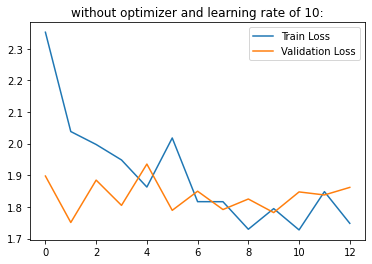

epoch: 0	loss: 2.327901830221572	validation loss: 2.1853501717344743	Epoch elapsed time: 3.02
epoch: 100	loss: 1.6686517360291147	validation loss: 1.7058501717344745	Epoch elapsed time: 2.46


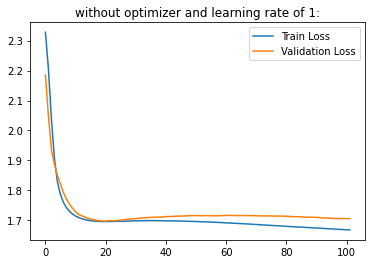

epoch: 0	loss: 2.3236454081757185	validation loss: 2.3870501717344745	Epoch elapsed time: 2.74
epoch: 100	loss: 1.700888413372476	validation loss: 1.7268501717344744	Epoch elapsed time: 4.31
epoch: 200	loss: 1.694367584273277	validation loss: 1.7142501717344745	Epoch elapsed time: 4.25
epoch: 300	loss: 1.699554920080372	validation loss: 1.7199501717344745	Epoch elapsed time: 4.45
epoch: 400	loss: 1.7015765438802544	validation loss: 1.7265501717344744	Epoch elapsed time: 4.3
epoch: 500	loss: 1.699704001784417	validation loss: 1.7293501717344746	Epoch elapsed time: 5.11


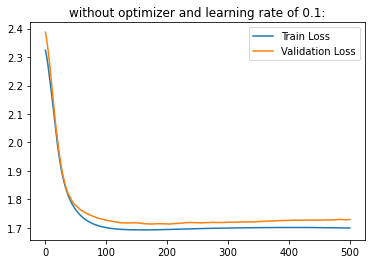

epoch: 0	loss: 2.3002561937221313	validation loss: 2.3757501717344747	Epoch elapsed time: 4.76
epoch: 100	loss: 2.1487532944022307	validation loss: 2.2262501717344745	Epoch elapsed time: 4.83
epoch: 200	loss: 1.9915537629213478	validation loss: 2.0498501717344744	Epoch elapsed time: 4.6
epoch: 300	loss: 1.8830295394736922	validation loss: 1.9463501717344744	Epoch elapsed time: 4.45
epoch: 400	loss: 1.8154553985508357	validation loss: 1.8748501717344745	Epoch elapsed time: 4.54
epoch: 500	loss: 1.7744356980581144	validation loss: 1.8244501717344745	Epoch elapsed time: 4.64


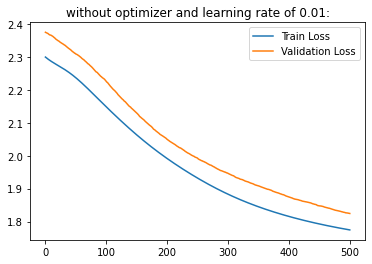

epoch: 0	loss: 2.315400859310267	validation loss: 2.3609501717344745	Epoch elapsed time: 4.69
epoch: 100	loss: 2.305545586829185	validation loss: 2.3481501717344746	Epoch elapsed time: 3.03
epoch: 200	loss: 2.2950131178665263	validation loss: 2.3297501717344744	Epoch elapsed time: 4.59
epoch: 300	loss: 2.2838121090656665	validation loss: 2.3134501717344746	Epoch elapsed time: 4.48
epoch: 400	loss: 2.271996439308905	validation loss: 2.2942501717344745	Epoch elapsed time: 4.53
epoch: 500	loss: 2.259556469198272	validation loss: 2.2726501717344747	Epoch elapsed time: 4.2


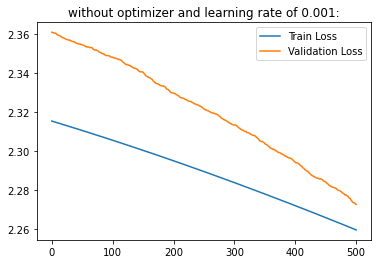

epoch: 0	loss: 2.340970331335297	validation loss: 2.3407501717344745	Epoch elapsed time: 4.24
epoch: 100	loss: 2.338974724111277	validation loss: 2.3391501717344747	Epoch elapsed time: 2.62
epoch: 200	loss: 2.336895518271228	validation loss: 2.3371501717344745	Epoch elapsed time: 1.88
epoch: 300	loss: 2.334750592274548	validation loss: 2.3343501717344743	Epoch elapsed time: 4.26
epoch: 400	loss: 2.3325580453421213	validation loss: 2.3327501717344745	Epoch elapsed time: 2.95
epoch: 500	loss: 2.3303354077557383	validation loss: 2.3301501717344744	Epoch elapsed time: 2.41


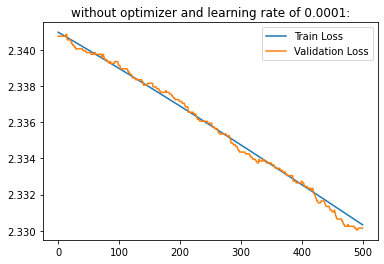

epoch: 0	loss: 2.320015049214646	validation loss: 1.9179501717344745	Epoch elapsed time: 2.45


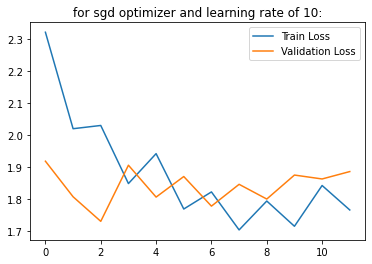

epoch: 0	loss: 2.321510711783884	validation loss: 2.1858501717344745	Epoch elapsed time: 3.56


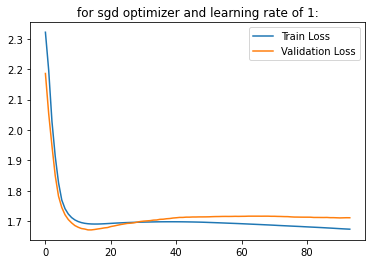

epoch: 0	loss: 2.3153350769146597	validation loss: 2.3468501717344745	Epoch elapsed time: 3.23
epoch: 100	loss: 1.704593041040888	validation loss: 1.6890501717344746	Epoch elapsed time: 3.22
epoch: 200	loss: 1.6989796722703645	validation loss: 1.6853501717344745	Epoch elapsed time: 2.62
epoch: 300	loss: 1.7017461528465687	validation loss: 1.6994501717344745	Epoch elapsed time: 2.7
epoch: 400	loss: 1.7021419121868449	validation loss: 1.7096501717344745	Epoch elapsed time: 2.62
epoch: 500	loss: 1.6993808926124236	validation loss: 1.7142501717344745	Epoch elapsed time: 3.14


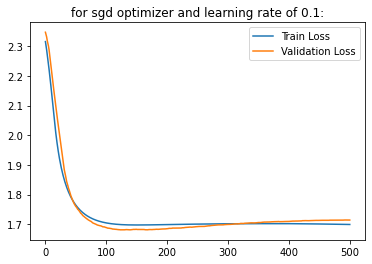

epoch: 0	loss: 2.308794305401738	validation loss: 2.3462501717344746	Epoch elapsed time: 3.31
epoch: 100	loss: 2.146433917890798	validation loss: 2.2013501717344743	Epoch elapsed time: 3.56
epoch: 200	loss: 1.9793011531048883	validation loss: 2.0344501717344743	Epoch elapsed time: 3.41
epoch: 300	loss: 1.87103586971548	validation loss: 1.9080501717344744	Epoch elapsed time: 3.93
epoch: 400	loss: 1.8074141400856472	validation loss: 1.8324501717344746	Epoch elapsed time: 3.14
epoch: 500	loss: 1.7686225025290883	validation loss: 1.7836501717344746	Epoch elapsed time: 2.76


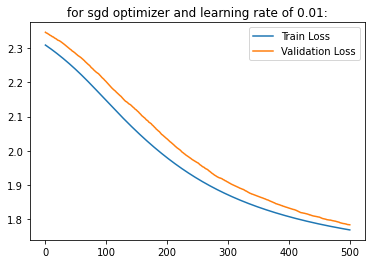

epoch: 0	loss: 2.338902646201903	validation loss: 2.3249501717344745	Epoch elapsed time: 2.55
epoch: 100	loss: 2.306951580118427	validation loss: 2.2999501717344746	Epoch elapsed time: 2.63
epoch: 200	loss: 2.27590136875841	validation loss: 2.2805501717344745	Epoch elapsed time: 3.86
epoch: 300	loss: 2.2511386965565854	validation loss: 2.2597501717344746	Epoch elapsed time: 3.28
epoch: 400	loss: 2.2303884826557727	validation loss: 2.2410501717344746	Epoch elapsed time: 3.98
epoch: 500	loss: 2.2116141361413835	validation loss: 2.2212501717344746	Epoch elapsed time: 3.71


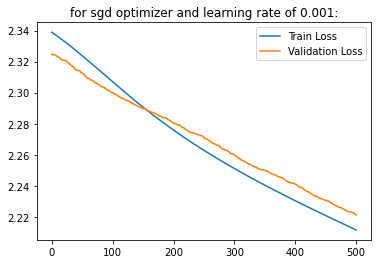

epoch: 0	loss: 2.3137587163695836	validation loss: 2.3801501717344746	Epoch elapsed time: 3.75
epoch: 100	loss: 2.312418271720599	validation loss: 2.3788501717344746	Epoch elapsed time: 4.79
epoch: 200	loss: 2.311068251983022	validation loss: 2.3778501717344747	Epoch elapsed time: 4.37
epoch: 300	loss: 2.309708641072877	validation loss: 2.3765501717344746	Epoch elapsed time: 4.73
epoch: 400	loss: 2.3083394065474647	validation loss: 2.3750501717344745	Epoch elapsed time: 4.03
epoch: 500	loss: 2.3069605010851686	validation loss: 2.3741501717344744	Epoch elapsed time: 3.34


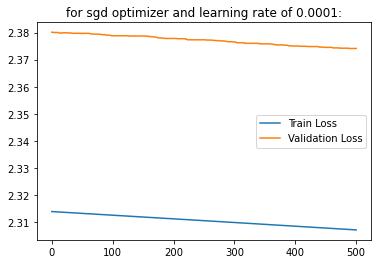

epoch: 0	loss: 2.3737478338134768	validation loss: 2.3247501717344745	Epoch elapsed time: 3.43


C:\Users\esmae\AppData\Local\Temp/ipykernel_22896/220706803.py:33: RuntimeWarning: overflow encountered in exp
  'sigmoid':  {'func' :(lambda x: 1/(1+np.exp(-x))),


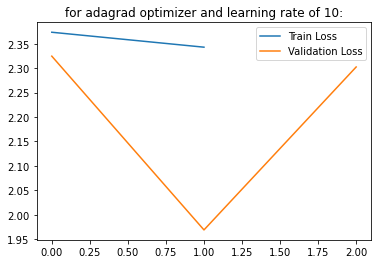

epoch: 0	loss: 2.3334122677288485	validation loss: 1.8744501717344746	Epoch elapsed time: 3.31


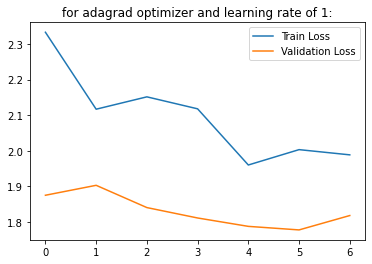

epoch: 0	loss: 2.3243608722413356	validation loss: 1.9272501717344745	Epoch elapsed time: 3.37


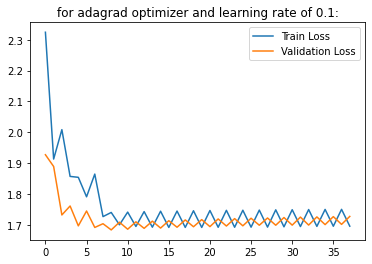

epoch: 0	loss: 2.3565416242938584	validation loss: 2.0694501717344744	Epoch elapsed time: 3.18
epoch: 100	loss: 1.601404384760654	validation loss: 1.5928501717344745	Epoch elapsed time: 4.56
epoch: 200	loss: 1.5988423141237547	validation loss: 1.5949501717344745	Epoch elapsed time: 2.22
epoch: 300	loss: 1.5968701390529263	validation loss: 1.5965501717344746	Epoch elapsed time: 4.71


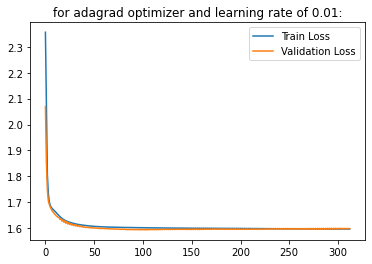

epoch: 0	loss: 2.342853659152981	validation loss: 2.3812501717344743	Epoch elapsed time: 3.71
epoch: 100	loss: 1.6591091033217378	validation loss: 1.6454501717344745	Epoch elapsed time: 1.92
epoch: 200	loss: 1.6209848830797549	validation loss: 1.6176501717344745	Epoch elapsed time: 4.53
epoch: 300	loss: 1.5997916926830358	validation loss: 1.5965501717344746	Epoch elapsed time: 3.05
epoch: 400	loss: 1.5875784551116847	validation loss: 1.5862501717344746	Epoch elapsed time: 3.28
epoch: 500	loss: 1.580376884503233	validation loss: 1.5802501717344746	Epoch elapsed time: 3.19


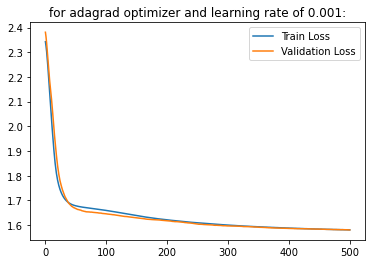

epoch: 0	loss: 2.338076509099079	validation loss: 2.3555501717344747	Epoch elapsed time: 3.18
epoch: 100	loss: 1.9945251851873176	validation loss: 1.9786501717344744	Epoch elapsed time: 4.74
epoch: 200	loss: 1.7761098340317913	validation loss: 1.7947501717344745	Epoch elapsed time: 3.24
epoch: 300	loss: 1.7073867363674136	validation loss: 1.7218501717344745	Epoch elapsed time: 3.86
epoch: 400	loss: 1.6823829191770363	validation loss: 1.6934501717344745	Epoch elapsed time: 3.92
epoch: 500	loss: 1.6714329514255486	validation loss: 1.6786501717344744	Epoch elapsed time: 3.38


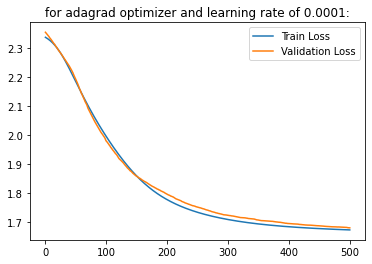

epoch: 0	loss: 2.3222471751910696	validation loss: 2.3482501717344744	Epoch elapsed time: 4.63


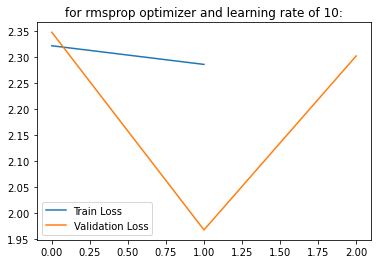

epoch: 0	loss: 2.3381289420765627	validation loss: 2.1209501717344743	Epoch elapsed time: 4.6


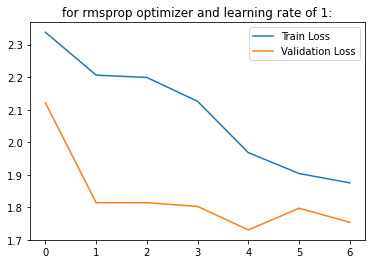

epoch: 0	loss: 2.346275614017013	validation loss: 1.8284501717344745	Epoch elapsed time: 4.67


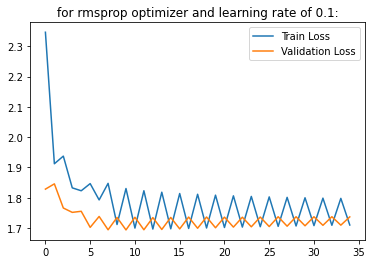

epoch: 0	loss: 2.3134017347383677	validation loss: 1.9422501717344745	Epoch elapsed time: 5.22
epoch: 100	loss: 1.5983996774561662	validation loss: 1.5932501717344745	Epoch elapsed time: 5.35
epoch: 200	loss: 1.5963246965454914	validation loss: 1.5953501717344745	Epoch elapsed time: 4.0
epoch: 300	loss: 1.5949357444109165	validation loss: 1.5971501717344745	Epoch elapsed time: 2.98


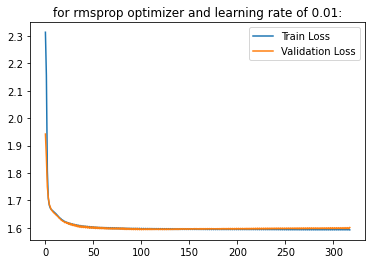

epoch: 0	loss: 2.3121626604651673	validation loss: 2.3228501717344745	Epoch elapsed time: 4.32
epoch: 100	loss: 1.6533168707446024	validation loss: 1.6510501717344745	Epoch elapsed time: 4.33
epoch: 200	loss: 1.6181681057435389	validation loss: 1.6167501717344746	Epoch elapsed time: 4.26
epoch: 300	loss: 1.5987477964987582	validation loss: 1.5966501717344745	Epoch elapsed time: 4.29
epoch: 400	loss: 1.5878252220794329	validation loss: 1.5868501717344745	Epoch elapsed time: 4.18
epoch: 500	loss: 1.5811453626582914	validation loss: 1.5805501717344745	Epoch elapsed time: 4.39


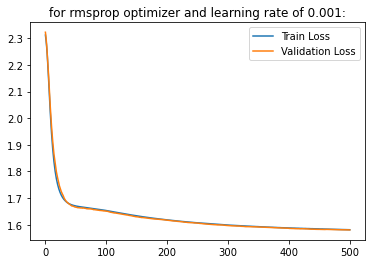

epoch: 0	loss: 2.3254999021225884	validation loss: 2.3607501717344745	Epoch elapsed time: 4.2
epoch: 100	loss: 2.0277426498916484	validation loss: 1.9950501717344744	Epoch elapsed time: 4.13
epoch: 200	loss: 1.8112339728165319	validation loss: 1.8058501717344746	Epoch elapsed time: 4.21
epoch: 300	loss: 1.7315571026879975	validation loss: 1.7217501717344745	Epoch elapsed time: 2.76
epoch: 400	loss: 1.704329039233795	validation loss: 1.6823501717344744	Epoch elapsed time: 2.77
epoch: 500	loss: 1.6937859325321056	validation loss: 1.6652501717344745	Epoch elapsed time: 2.7


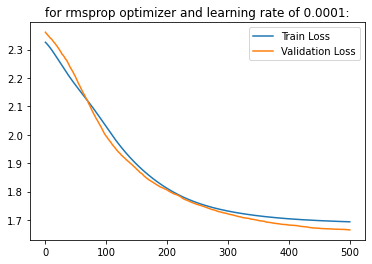

In [3]:
# Optimizer and learning rate evaluation

np.random.seed(42)
Models = {}
   
for opt in [None,'sgd','adagrad','rmsprop']:
    for lr in [10,1,0.1,0.01,0.001,0.0001]:
    
        M = NeuralNetwrok()

        M.add_layer(28*28)
        M.add_layer(500,'sigmoid')
        M.add_layer(10,'softmax')


        M.fit(x_train,y_train,epochs = 500, verbos = 100, learning_rate = lr,
              validation=True, xval=x_val, yval=y_val, optimizer = opt)

        plt.plot(M.loss_history)
        plt.plot(M.val_history)
        plt.legend(['Train Loss','Validation Loss'])
        
        if opt == None:
            opt1 = 'without'
            plt.title('{} optimizer and learning rate of {}:'.format(opt1,lr))
            
        else:    
            plt.title('{} optimizer and learning rate of {}:'.format('for '+opt,lr))
        
        plt.show()

        Models['{} {}'.format(lr,opt)] = M

        del M

epoch: 0	loss: 2.3475541530609108	validation loss: 2.3490501717344743	Epoch elapsed time: 2.03
epoch: 100	loss: 1.6557223846388665	validation loss: 1.6588501717344746	Epoch elapsed time: 4.84
epoch: 200	loss: 1.6197833309610996	validation loss: 1.6220501717344744	Epoch elapsed time: 4.28
epoch: 300	loss: 1.6005072924024206	validation loss: 1.6013501717344745	Epoch elapsed time: 4.19
epoch: 400	loss: 1.5897219664304767	validation loss: 1.5893501717344745	Epoch elapsed time: 4.09
epoch: 500	loss: 1.5830847733978721	validation loss: 1.5805501717344745	Epoch elapsed time: 4.19


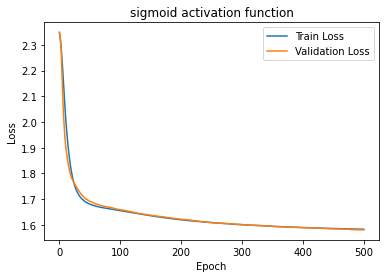

epoch: 0	loss: 2.3418084949707367	validation loss: 2.3328501717344743	Epoch elapsed time: 3.49


C:\Users\esmae\AppData\Local\Temp/ipykernel_22896/220706803.py:35: RuntimeWarning: invalid value encountered in true_divide
  'softmax':  {'func' :(lambda x: np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum(axis=1, keepdims=True)),


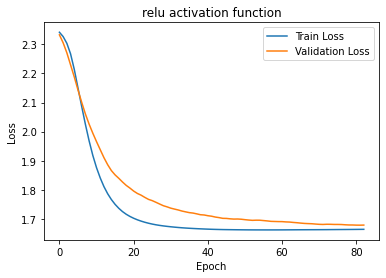

epoch: 0	loss: 2.3635478925480413	validation loss: 2.3571501717344745	Epoch elapsed time: 3.39
epoch: 100	loss: 1.6720116669058818	validation loss: 1.6697501717344745	Epoch elapsed time: 3.4
epoch: 200	loss: 1.6695193889840556	validation loss: 1.6672501717344745	Epoch elapsed time: 3.15
epoch: 300	loss: 1.6735958478513986	validation loss: 1.6695501717344745	Epoch elapsed time: 3.07
epoch: 400	loss: 1.6795821271468265	validation loss: 1.6727501717344746	Epoch elapsed time: 3.36
epoch: 500	loss: 1.6851991805583066	validation loss: 1.6741501717344744	Epoch elapsed time: 3.76


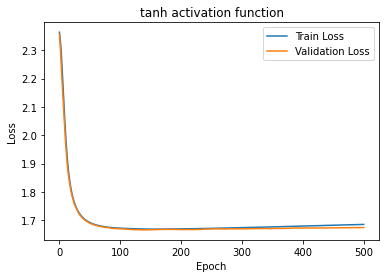

In [5]:
# Activation Function evaluation
Models1 = {}
for af in ['sigmoid','relu','tanh']:
    
    M = NeuralNetwrok()

    M.add_layer(28*28)
    M.add_layer(500,af)
    M.add_layer(10,'softmax')


    
    M.fit(x_train,y_train,epochs = 500, verbos = 100, optimizer = 'adagrad',
          learning_rate = 0.001 ,validation=True, xval=x_val, yval=y_val)

    plt.plot(M.loss_history)
    plt.plot(M.val_history)
    plt.legend(['Train Loss','Validation Loss'])
    plt.title('{} activation function'.format(af))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    Models1[af] = M
    
    del M

epoch: 0	loss: 2.3455454858776466	validation loss: 2.3227501717344743	Epoch elapsed time: 8.52
epoch: 20	loss: 1.692376741724147	validation loss: 1.7410501717344744	Epoch elapsed time: 8.28
epoch: 40	loss: 1.6601169728496776	validation loss: 1.6832501717344746	Epoch elapsed time: 8.32
epoch: 60	loss: 1.6532670998305863	validation loss: 1.6653501717344745	Epoch elapsed time: 8.07
epoch: 80	loss: 1.6478680274897162	validation loss: 1.6544501717344744	Epoch elapsed time: 8.16
epoch: 100	loss: 1.642434389975011	validation loss: 1.6459501717344744	Epoch elapsed time: 8.07


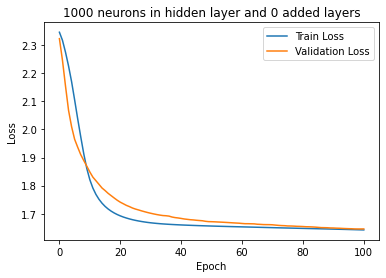

epoch: 0	loss: 2.3236454081757185	validation loss: 2.3788501717344746	Epoch elapsed time: 4.36
epoch: 20	loss: 1.768323477934014	validation loss: 1.7788501717344745	Epoch elapsed time: 4.28
epoch: 40	loss: 1.6888954430027276	validation loss: 1.7061501717344745	Epoch elapsed time: 4.53
epoch: 60	loss: 1.6725425434197019	validation loss: 1.6771501717344746	Epoch elapsed time: 2.84
epoch: 80	loss: 1.6645081715943024	validation loss: 1.6640501717344744	Epoch elapsed time: 2.86
epoch: 100	loss: 1.657417347652737	validation loss: 1.6540501717344744	Epoch elapsed time: 3.05


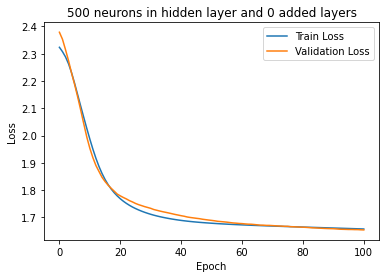

epoch: 0	loss: 2.29440428395044	validation loss: 2.3238501717344744	Epoch elapsed time: 0.9
epoch: 20	loss: 2.1264320336139644	validation loss: 2.0134501717344744	Epoch elapsed time: 0.92
epoch: 40	loss: 1.936883284782687	validation loss: 1.8701501717344744	Epoch elapsed time: 1.03
epoch: 60	loss: 1.835747736415519	validation loss: 1.7899501717344746	Epoch elapsed time: 0.92
epoch: 80	loss: 1.7784905554645374	validation loss: 1.7493501717344746	Epoch elapsed time: 0.95
epoch: 100	loss: 1.7423389659624215	validation loss: 1.7252501717344746	Epoch elapsed time: 0.92


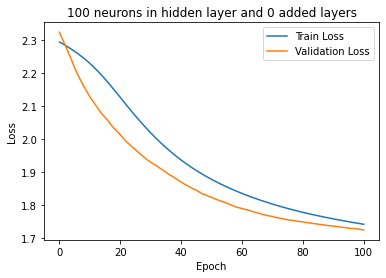

In [9]:
# learning rate evaluation
np.random.seed(42)
Models2 = {}
for size in [1000,500,100]:
    for N in [0]:
        

        M = NeuralNetwrok()

        M.add_layer(28*28)
        M.add_layer(size,'sigmoid')
        
        for i in range(N):
            M.add_layer(200,'sigmoid')
        
        M.add_layer(10,'softmax')



        M.fit(x_train,y_train,epochs = 100, verbos = 20, optimizer = 'adagrad',
              learning_rate = 0.001 ,validation=True, xval=x_val, yval=y_val)

        plt.plot(M.loss_history)
        plt.plot(M.val_history)
        plt.legend(['Train Loss','Validation Loss'])   
        plt.title('{} neurons in hidden layer and {} added layers'.format(size, N))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show() 
    
    
    Models2['{},{}'.format(size,N)] = M
    
    del M

epoch: 0	loss: 2.3518858622715917	validation loss: 2.3673501717344747	Epoch elapsed time: 4.18
epoch: 20	loss: 1.7976881025103355	validation loss: 1.8267501717344745	Epoch elapsed time: 3.15
epoch: 40	loss: 1.696007887419881	validation loss: 1.7112501717344746	Epoch elapsed time: 4.33
epoch: 60	loss: 1.6734959012738542	validation loss: 1.6769501717344746	Epoch elapsed time: 4.43
epoch: 80	loss: 1.6640837742436017	validation loss: 1.6646501717344746	Epoch elapsed time: 4.33
epoch: 100	loss: 1.6553488007220327	validation loss: 1.6568501717344746	Epoch elapsed time: 3.09


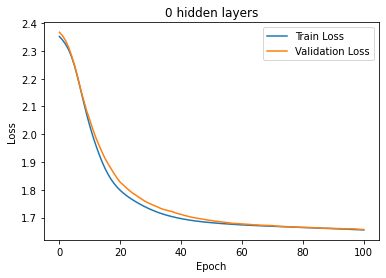

epoch: 0	loss: 2.3154038578346863	validation loss: 2.3275501717344746	Epoch elapsed time: 5.89
epoch: 20	loss: 1.795743587614256	validation loss: 1.8448501717344745	Epoch elapsed time: 5.7
epoch: 40	loss: 1.6790894978073472	validation loss: 1.7424501717344745	Epoch elapsed time: 5.94
epoch: 60	loss: 1.629748601357262	validation loss: 1.6985501717344744	Epoch elapsed time: 5.56
epoch: 80	loss: 1.6013069187914186	validation loss: 1.6867501717344744	Epoch elapsed time: 5.61
epoch: 100	loss: 1.584105323762938	validation loss: 1.6904501717344744	Epoch elapsed time: 5.83


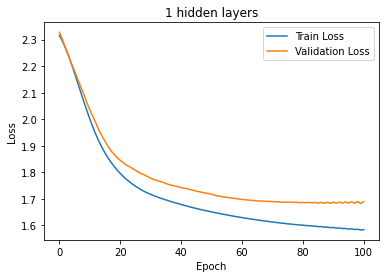

epoch: 0	loss: 2.3288593016775208	validation loss: 2.3946501717344746	Epoch elapsed time: 6.69
epoch: 20	loss: 1.786152328550769	validation loss: 1.7526501717344745	Epoch elapsed time: 6.73
epoch: 40	loss: 1.6735530458195824	validation loss: 1.6818501717344745	Epoch elapsed time: 4.61
epoch: 60	loss: 1.6339659888658602	validation loss: 1.6632501717344745	Epoch elapsed time: 3.49
epoch: 80	loss: 1.606951301764368	validation loss: 1.6638501717344745	Epoch elapsed time: 3.29
epoch: 100	loss: 1.5877028762643997	validation loss: 1.6698501717344745	Epoch elapsed time: 4.93


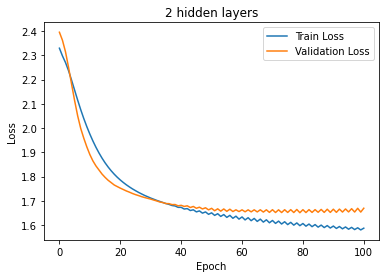

In [11]:
# Model Architecture evaluation
np.random.seed(42)
Models3 = {}
for N in [0,1,2]:
    
    M = NeuralNetwrok()

    M.add_layer(28*28)
    M.add_layer(500,'sigmoid')
    
    for i in range(N):
        M.add_layer(200,'sigmoid')
        
    M.add_layer(10,'softmax')


    
    M.fit(x_train,y_train,epochs = 100, verbos = 20, optimizer = 'adagrad',
          learning_rate = 0.001 ,validation=True, xval=x_val, yval=y_val)

    plt.plot(M.loss_history)
    plt.plot(M.val_history)
    plt.legend(['Train Loss','Validation Loss'])
    plt.title('{} hidden layers'.format(N))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    
    Models3[N] = M
    
    del M

with the plot and loss value for training and validation dataset we would chose these parameters for our final sugessted network:

- Activation function: sigmoid
- Optimizer and learning rate: Adagrad, 0.01
- Architecture: 784/500/10
- And also as we decided at the beginning, the loss function is cross entropy and last layer’s activation function is softmax.

We should note that in our test 1000 neurons for first hidden layer performed a little bit better but it was time consuming and in terms of required time for each epochs, it was twice as 500 neurons in the first hidden layer.




## Testing model with tuned parameters

Now that we know optimal parameters for our network, we can train a new model and use it to predict test dataset. Comparing the prediction to y_test gives us the accuracy of our model.

epoch: 0	loss: 2.3518858622715917	validation loss: 2.3673501717344747	Epoch elapsed time: 2.17
epoch: 100	loss: 1.6553488007220327	validation loss: 1.6568501717344746	Epoch elapsed time: 2.92
epoch: 200	loss: 1.6165414251917591	validation loss: 1.6224501717344746	Epoch elapsed time: 3.21
epoch: 300	loss: 1.5959799003157853	validation loss: 1.6053501717344745	Epoch elapsed time: 1.93
epoch: 400	loss: 1.5842678061476883	validation loss: 1.5902501717344746	Epoch elapsed time: 2.62
epoch: 500	loss: 1.5773023647878581	validation loss: 1.5803501717344746	Epoch elapsed time: 2.49


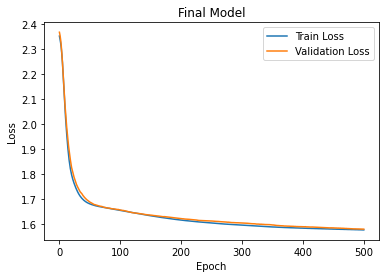

In [13]:
# Final Model
np.random.seed(42)
    
M = NeuralNetwrok()

M.add_layer(28*28)
M.add_layer(500,'sigmoid')       
M.add_layer(10,'softmax')

M.fit(x_train,y_train,epochs = 500, verbos = 100, optimizer = 'adagrad',
      loss_func = 'cross_ent',learning_rate = 0.01 ,
      validation=True, xval=x_val, yval=y_val)

plt.plot(M.loss_history)
plt.plot(M.val_history)
plt.title('Final Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()


In [14]:
M.evaluate(x_test,y_test)

88.07000000000001

As we can see the model resulted an acceptable result for our dataset.